In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

#for images
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from torchvision import models


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive/emergency_vs_non-emergency_dataset')

In [4]:
train = pd.read_csv('emergency_train.csv')
train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [9]:
train_img = []
for img_name in tqdm(train['image_names']):
  img_path = 'images/' + img_name
  img = imread(img_path)
  img = img / 255
  img = resize(img, (224, 224, 3), mode = 'constant', anti_aliasing=True)
  img = img.astype('float32')
  train_img.append(img)

100%|██████████| 1646/1646 [00:30<00:00, 54.64it/s]


In [10]:
x_train = np.array(train_img)
x_train.shape


(1646, 224, 224, 3)

It is an emergency vehicle


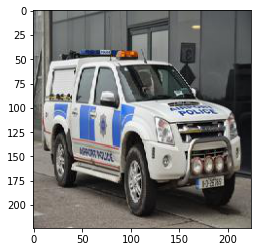

In [12]:
index = 10
plt.imshow(x_train[index])

if train['emergency_or_not'][index] == 1:
  print("It is an emergency vehicle")

else:
  print("It is not an emergency vehicle")  

It is not an emergency vehicle


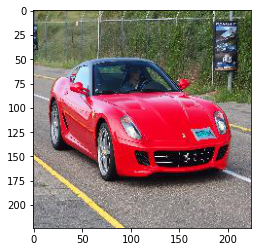

In [16]:
index = 2
plt.imshow(x_train[index])

if train['emergency_or_not'][index] == 1:
  print("It is an emergency vehicle")

else:
  print("It is not an emergency vehicle")  

In [18]:
y_train = train['emergency_or_not'].values
y_train[:5]

array([0, 0, 0, 0, 0])

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 1, stratify = y_train)

In [24]:
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)

((torch.Size([1481, 3, 224, 224]), torch.Size([1481])),
 (torch.Size([165, 3, 224, 224]), torch.Size([165])))

In [21]:
x_train = x_train.reshape(1481, 3, 224, 224)
x_train = torch.from_numpy(x_train)

y_train = y_train.astype(int)
y_train = torch.from_numpy(y_train)

x_train.shape, y_train.shape

(torch.Size([1481, 3, 224, 224]), torch.Size([1481]))

In [ ]:
x_val = x_val.reshape(165, 3, 224, 224)
x_val = torch.from_numpy(x_val)

y_val = y_val.astype(int)
y_val = torch.from_numpy(y_val)

x_val.shape, y_val.shape

In [26]:
class Net(Module):

  def __init__(self):
    super(Net, self).__init__()

    self.cnn_layers = Sequential(
              Conv2d(3, 4, kernel_size=3, stride = 1, padding = 1),
              BatchNorm2d(4),
              ReLU(inplace = True),
              MaxPool2d(kernel_size=2, stride = 2),
              Conv2d(4, 8, kernel_size=3, stride = 1, padding = 1),
              BatchNorm2d(8),
              ReLU(inplace = True),
              MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.linear_layers = Sequential(
        Linear(8 * 56 * 56, 2)
    )

  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [34]:
model = Net()
optimizer = Adam(model.parameters(), lr = 0.0001)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()

print(model)  

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=25088, out_features=2, bias=True)
  )
)


In [33]:
batch_size = 128

list(range(0, x_train.size()[0], batch_size))

[0, 128, 256, 384, 512, 640, 768, 896, 1024, 1152, 1280, 1408]

In [37]:
batch_size = 128
n_epochs = 15

for epoch in range(1, n_epochs + 1):

  training_loss = []
  train_loss = 0.0
  permutation = torch.randperm(x_train.size()[0])


  for i in range(0, x_train.size()[0], batch_size):

    indices = permutation[i: i + batch_size]
    x_batch, y_batch = x_train[indices], y_train[indices]

    if torch.cuda.is_available():
      x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

    outputs = model(x_batch)
    optimizer.zero_grad() 
    loss = criterion(outputs, y_batch)

    training_loss.append(loss.item())
    loss.backward()
    optimizer.step()

  training_loss = np.average(training_loss)  
  print('epoch: \t', epoch, '\t training loss: \t', training_loss)


epoch: 	 1 	 training loss: 	 0.7586590001980463
epoch: 	 2 	 training loss: 	 0.6229518602291743
epoch: 	 3 	 training loss: 	 0.5810491144657135
epoch: 	 4 	 training loss: 	 0.5533753857016563
epoch: 	 5 	 training loss: 	 0.5280888800819715
epoch: 	 6 	 training loss: 	 0.5020628670851389
epoch: 	 7 	 training loss: 	 0.49877865612506866
epoch: 	 8 	 training loss: 	 0.46970150371392566
epoch: 	 9 	 training loss: 	 0.4492438609401385
epoch: 	 10 	 training loss: 	 0.429949293533961
epoch: 	 11 	 training loss: 	 0.4176015580693881
epoch: 	 12 	 training loss: 	 0.40591494739055634
epoch: 	 13 	 training loss: 	 0.4034900988141696
epoch: 	 14 	 training loss: 	 0.37138432015975315
epoch: 	 15 	 training loss: 	 0.3574259579181671


In [42]:
#training accuracy records

prediction = []
target = []
permutation = torch.randperm(x_train.size()[0])

for i in tqdm(range(0, x_train.size()[0], batch_size)):
  indices = permutation[i : i+batch_size]
  x_batch, y_batch = x_train[indices], y_train[indices]

  if torch.cuda.is_available():
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

  with torch.no_grad():
    output = model(x_batch.cuda())

  softmax = torch.exp(output).cpu()
  prob = list(softmax.numpy())
  predictions = np.argmax(prob, axis=1)
  prediction.append(predictions)
  target.append(y_batch)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('\t Training accuracy: \t', np.average(accuracy))  



100%|██████████| 12/12 [00:00<00:00, 13.82it/s]

	 Training accuracy: 	 0.9059111015981736


In [45]:
prediction_val = []
target_val = []
permutation = torch.randperm(x_val.size()[0])

for i in tqdm(range(0, x_val.size()[0], batch_size)):
  indices = permutation[i : i+batch_size]
  x_batch, y_batch = x_val[indices], y_val[indices]

  if torch.cuda.is_available():
    x_batch, y_batch = x_batch.cuda(), y_batch.cuda()

  with torch.no_grad():
    output = model(x_batch.cuda())

  softmax = torch.exp(output).cpu()
  prob = list(softmax.numpy())
  predictions = np.argmax(prob, axis=1)
  prediction_val.append(predictions)
  target_val.append(y_batch)
    
# training accuracy
val_accuracy = []
for i in range(len(prediction_val)):
    val_accuracy.append(accuracy_score(target_val[i].cpu(), prediction_val[i]))
    
print('\t Validation accuracy: \t', np.average(val_accuracy))  


100%|██████████| 2/2 [00:00<00:00, 18.03it/s]

	 Validation accuracy: 	 0.6620565878378378
